Accessing via the API per the suggested jupyter notebook was complex. Trying earthaccess python package. 


In [3]:
import earthaccess
import rioxarray as rxr
import xarray as xr

/Users/CraigC/Documents/Learning/Mapping_Coding/Projects/can_i_ride_research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
auth = earthaccess.login()
# auth = earthaccess.login(strategy="netrc")


In [3]:
results = earthaccess.search_datasets(
    count=-1,
    short_name='SPL4SMLM',
    version='008',
    daac='NSIDC',
    bounding_box=(-126, 24, -65, 50),
    temporal=("2025-05-20", "2025-05-30")
)



In [4]:
for result in results:
    print(result.services)

<bound method DataCollection.services of {
  "meta": {
    "revision-id": 4,
    "deleted": false,
    "format": "application/iso19115+xml",
    "provider-id": "NSIDC_ECS",
    "has-combine": false,
    "user-id": "crumlyd",
    "has-formats": true,
    "associations": {
      "services": [
        "S1568899363-NSIDC_ECS",
        "S2011758375-NSIDC_ECS",
        "S1956579962-NSIDC_ECS"
      ],
      "tools": [
        "TL1977971361-NSIDC_ECS",
        "TL3010466318-NSIDC_CPRD",
        "TL2013523138-NSIDC_ECS",
        "TL2011654705-NSIDC_ECS",
        "TL2000645101-NSIDC_ECS"
      ]
    },
    "has-spatial-subsetting": true,
    "native-id": "SMAP L4 Global 9 km EASE-Grid Surface and Root Zone Soil Moisture Land Model Constants V008",
    "has-transforms": true,
    "association-details": {
      "services": [
        {
          "data": {
            "order_option": "OO3498311625-NSIDC_ECS"
          },
          "concept-id": "S1568899363-NSIDC_ECS"
        },
        {
         

In [5]:
data = earthaccess.search_data(
    count=-1,
    short_name='SPL4SMGP',
    version='008',
    daac='NSIDC',
    provider='NSIDC_ECS',
    doi='10.5067/T5RUATAQREF8',
    bounding_box=(-126, 24, -65, 50),
    temporal=("2025-06-05", "2025-06-05"),
)

In [6]:
httpfile = earthaccess.open(data, provider='NSIDC_ECS')


QUEUEING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 4888.47it/s]
PROCESSING TASKS | : 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]
COLLECTING RESULTS | : 100%|██████████| 9/9 [00:00<00:00, 59634.65it/s]


In [7]:
earthaccess.download(data, "./data", provider='NSIDC_ECS')

QUEUEING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 271.22it/s]
PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]Error while downloading the file SMAP_L4_SM_gph_20250605T103000_Vv8011_001.h5
Traceback (most recent call last):
  File "/Users/CraigC/Documents/Learning/Mapping_Coding/Projects/can_i_ride_research/.venv/lib/python3.13/site-packages/earthaccess/store.py", line 697, in _download_file
    r.raise_for_status()
    ~~~~~~~~~~~~~~~~~~^^
  File "/Users/CraigC/Documents/Learning/Mapping_Coding/Projects/can_i_ride_research/.venv/lib/python3.13/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP4/SMAP/SPL4SMGP.008/2025.06.05/SMAP_L4_SM_gph_20250605T103000_Vv8011_001.h5
PROCESSING TASKS | :  22%|██▏       | 2/9 [00:00<00:01,  6.45it/s]Error while downloading the file SMAP_L4_SM_gph_20250605T073000_Vv

KeyboardInterrupt: 

In [103]:
# smap_20250604 = xr.open_mfdataset(httpfile, engine='h5netcdf') #need to have dask installed to use mfdataset. Couldn't get "open_dataset" to work
ds_smap = xr.open_dataset("data/smap/SMAP_L4_SM_gph_20250604T223000_Vv8011_001.h5", engine="h5netcdf", group='Geophysical_Data')
ds_smap_all = xr.open_dataset("data/smap/SMAP_L4_SM_gph_20250604T223000_Vv8011_001.h5", engine="h5netcdf")

/var/folders/dd/wl713n7x6wbdfmqn8dtqv5280000gp/T/ipykernel_8045/2149817645.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  ds_smap = xr.open_dataset("data/smap/SMAP_L4_SM_gph_20250604T223000_Vv8011_001.h5", engine="h5netcdf", group='Geophysical_Data')
/var/folders/dd/wl713n7x6wbdfmqn8dtqv5280000gp/T/ipykernel_8045/2149817645.py:3: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  ds_smap_all = xr.open_dataset("data/smap/SMAP_L4_SM_gph_20250604T223000_Vv8011_001.h5", engine="h5netcdf")


In [104]:
ds_smap

<xarray.Dataset> Size: 1GB
Dimensions:                            (y: 1624, x: 3856)
Dimensions without coordinates: y, x
Data variables: (12/45)
    baseflow_flux                      (y, x) float32 25MB ...
    depth_to_water_table_from_surface  (y, x) float32 25MB ...
    free_surface_water_on_peat_flux    (y, x) float32 25MB ...
    heat_flux_ground                   (y, x) float32 25MB ...
    heat_flux_latent                   (y, x) float32 25MB ...
    heat_flux_sensible                 (y, x) float32 25MB ...
    ...                                 ...
    specific_humidity_lowatmmodlay     (y, x) float32 25MB ...
    surface_pressure                   (y, x) float32 25MB ...
    surface_temp                       (y, x) float32 25MB ...
    temp_lowatmmodlay                  (y, x) float32 25MB ...
    vegetation_greenness_fraction      (y, x) float32 25MB ...
    windspeed_lowatmmodlay             (y, x) float32 25MB ...

In [105]:
ds_smap_all

<xarray.Dataset> Size: 150MB
Dimensions:                  (phony_dim_0: 1, y: 1624, x: 3856)
Coordinates:
  * x                        (x) float64 31kB -1.736e+07 ... 1.736e+07
  * y                        (y) float64 13kB 7.31e+06 7.301e+06 ... -7.31e+06
Dimensions without coordinates: phony_dim_0
Data variables:
    EASE2_global_projection  (phony_dim_0) |S1 1B ...
    cell_column              (y, x) float64 50MB ...
    cell_lat                 (y, x) float32 25MB ...
    cell_lon                 (y, x) float32 25MB ...
    cell_row                 (y, x) float64 50MB ...
    time                     (phony_dim_0) datetime64[ns] 8B ...
Attributes:
    Comment:      HDF-5
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  CF
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv8011/...
    History:      File written by ldas2daac.x
    Institution:  NASA Global Modeling and Assimilation Office
    References:   see SMAP L4_SM Product Specification Documentation
    Source:       v18.1.0
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule

In [106]:
ds_smap_combined = ds_smap.merge(ds_smap_all[['cell_column', 'cell_row']]) #The data is on a projected grid (EASE 2.0), so I select the row and column rather than lat/long. 

In [107]:
ds_smap_combined

<xarray.Dataset> Size: 1GB
Dimensions:                            (y: 1624, x: 3856)
Coordinates:
  * x                                  (x) float64 31kB -1.736e+07 ... 1.736e+07
  * y                                  (y) float64 13kB 7.31e+06 ... -7.31e+06
Data variables: (12/47)
    baseflow_flux                      (y, x) float32 25MB ...
    depth_to_water_table_from_surface  (y, x) float32 25MB ...
    free_surface_water_on_peat_flux    (y, x) float32 25MB ...
    heat_flux_ground                   (y, x) float32 25MB ...
    heat_flux_latent                   (y, x) float32 25MB ...
    heat_flux_sensible                 (y, x) float32 25MB ...
    ...                                 ...
    surface_temp                       (y, x) float32 25MB ...
    temp_lowatmmodlay                  (y, x) float32 25MB ...
    vegetation_greenness_fraction      (y, x) float32 25MB ...
    windspeed_lowatmmodlay             (y, x) float32 25MB ...
    cell_column                        (y, x) float64 50MB ...
    cell_row                           (y, x) float64 50MB ...

In [108]:
# ds_smap_us = ds_smap.sel(y=slice(5556000, 2667000), x=slice(-14010000, -7223000)) Worked for original, but I think it needs to be by row/column for the geophysical_data
import math 

pixel_size = 9024.13
y_min = int(math.ceil(2667000 / pixel_size))
y_max = int(math.ceil(5556000 / pixel_size))
x_min = int(math.ceil(-14010000 / pixel_size))
x_max = int(math.ceil(-7223000 / pixel_size))



In [109]:
# ds_smap_us = ds_smap.sel(y=slice(y_min, y_max), x=slice(x_min, x_max)) # slicing by cells. Worked before based on ds without coordinates. 
# ds_smap_combined_us = ds_smap_combined.sel(y=slice(y_min, y_max), x=slice(x_min, x_max)) #Didn't work, becuase it now has coordinates.
ds_smap_combined_us = ds_smap_combined.sel(y=slice(5656000, 2667000), x=slice(-12310000, -6323000))

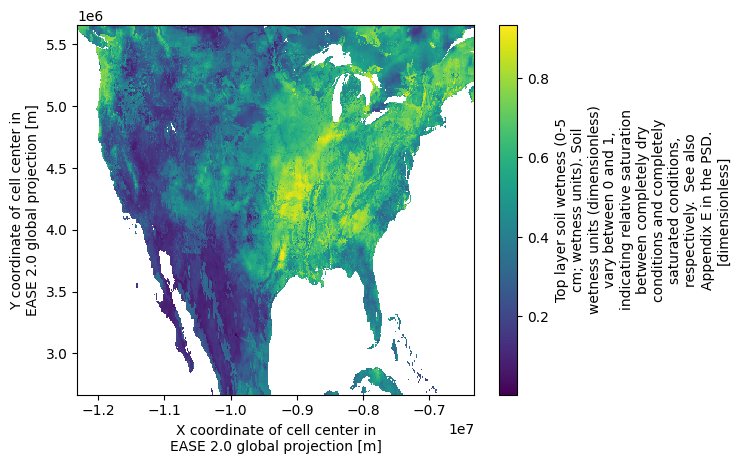

In [110]:
ds_smap_combined_us['sm_surface_wetness'].plot()

In [111]:
ds_combined_6931 = ds_smap_combined_us.rio.write_crs("EPSG:6933", inplace=True)

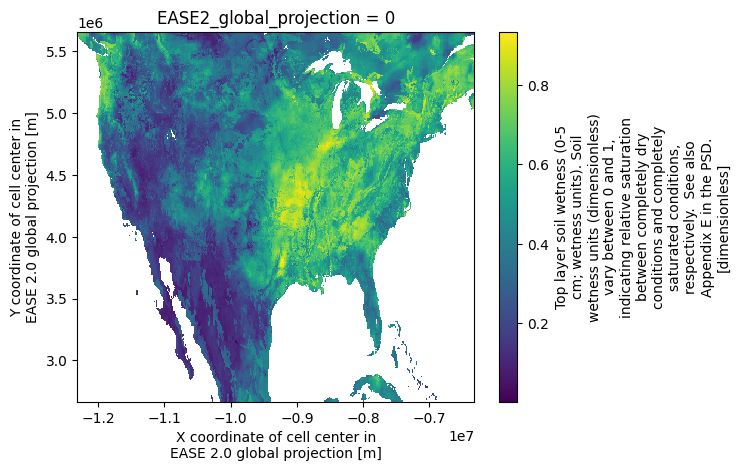

In [112]:
ds_combined_6931['sm_surface_wetness'].plot()

In [113]:
ds_smap_analysis = ds_smap_combined_us[['sm_surface', 'sm_surface_wetness', 'precipitation_total_surface_flux', 'overland_runoff_flux']]

In [114]:
ds_smap_combined_us['sm_surface_wetness']

<xarray.DataArray 'sm_surface_wetness' (y: 332, x: 665)> Size: 883kB
[220780 values with dtype=float32]
Coordinates:
  * x                        (x) float64 5kB -1.231e+07 -1.23e+07 ... -6.328e+06
  * y                        (y) float64 3kB 5.653e+06 5.644e+06 ... 2.671e+06
    EASE2_global_projection  int64 8B 0
Attributes:
    DIMENSION_LABELS:  [b'y', b'x']
    fmissing_value:    -9999.0
    long_name:         Top layer soil wetness (0-5 cm; wetness units). Soil w...
    units:             dimensionless
    valid_max:         1.0
    valid_min:         0.0

In [115]:
ds_smap_sw = ds_smap_combined_us['sm_surface_wetness']
# ds_smap_sw_masked = ds_smap_sw.where(ds_smap_sw != ds_smap_sw.attrs['fmissing_value']) Didn't seem to do anything. 

In [116]:
ds_smap_5070 = ds_smap_analysis.rio.reproject("EPSG:5070")

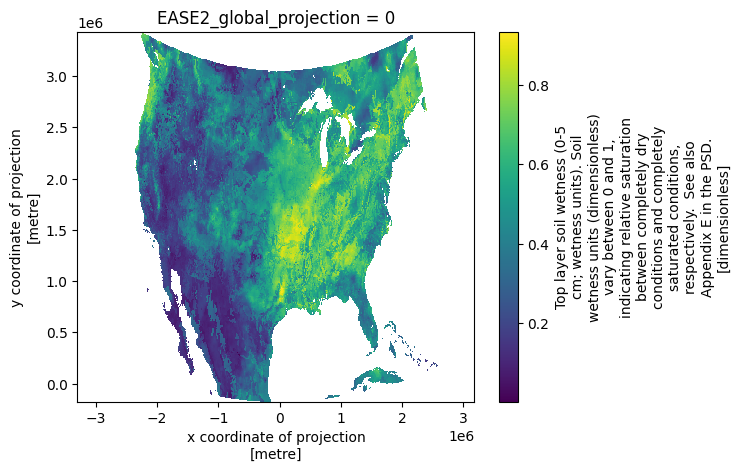

In [117]:
ds_smap_5070['sm_surface_wetness'].plot()

In [ ]:
# ds_smap_5070.to_netcdf("data/smap/ds_smap_5070.nc")